# **KAIST EE**
#  **[EE488] note 04E. Slime Volleyball Agent Test**
## **Instructor**: Prof. Yoon, Young-Gyu (ygyoon@kaist.ac.kr)
### This example code was prepared by EE488 teaching assistants Han, Seungjae (jay0118@kaist.ac.kr) & Shin, Changyeop (scey26@kaist.ac.kr).

- Class Date : 22.03.xx.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

---

1. As usual, let's start with importing libraries!

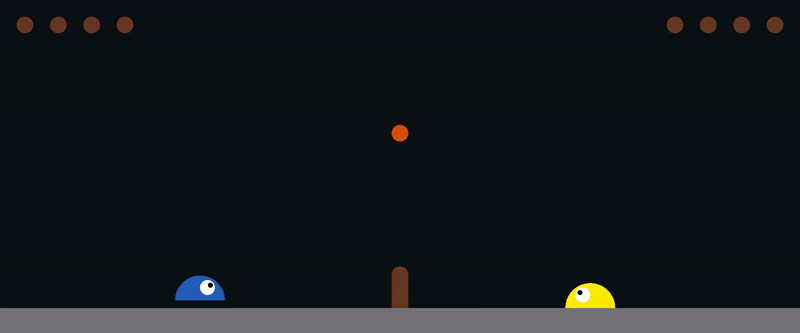

#<font color='red'> **CAUTION: DO NOT MODIFY ANY CODE EXCEPT CELL 8** </font>


### 1. Let's **mount Google drive** so that we can load files as we need.

In [12]:
from google.colab import drive
drive.mount("/content/drive")
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Let's Install **stable-baselines3** and **SlimeVolleyGym**.

In [13]:
!pip install slimevolleygym
!pip install stable-baselines3==1.4.0



### 3. Let's install a few more things to setup RL enviroment. 

In [14]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# Followings are for visualization (as we are running on server without a physical display!)
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

# Autoreload in case that the custom modules are changed
%load_ext autoreload
%autoreload 2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
The autoreload extension is already loaded. To reload it, us

### 4.  And then, let's **import the libraries** (including SlimeVolleyGym and stable-baselines3) we need to use.

In [15]:
import slimevolleygym
from slimevolleygym import FrameStack
import gym
import time
import torch
import base64

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, NoopResetEnv, MaxAndSkipEnv, WarpFrame
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import A2C, DQN, PPO, SAC
from stable_baselines3.common.vec_env import VecFrameStack

import cv2

import random

### 5. We need a bunch of stuff for **visualization** (as we are running on server without a physical display!). Let's not worry about the details here.

In [16]:
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import Monitor as eval_Monitor
import matplotlib.pyplot as plt
import numpy as np
import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### 6. Here's our function for visualization of the result as a **video**.

In [17]:
def show_video(episode, rnd):
  mp4list = glob.glob(f'video_{episode}_{rnd}/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    os.system(f"ffmpeg -i {mp4} -vcodec libx264 video_{episode}_{rnd}/compressed.mp4")
    video = io.open(f'video_{episode}_{rnd}/compressed.mp4', 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env, episode, rnd):
    env = eval_Monitor(env, f'./video_{episode}_{rnd}', force=True)
    return env

###7. To make two agents play the game, we have to modify wrappers. Let's not worry about the details here.

In [18]:
class SlimeVolleyOpponentEnv(slimevolleygym.SlimeVolleyEnv):
    def __init__(self, opponent):
        super(SlimeVolleyOpponentEnv, self).__init__()
        self.policy = self
        self.opponent = opponent
        # self.otherAction = [0, 0, 0]

    def predict(self, obs):
        action, _ = self.opponent.predict(obs)
        return action
        
    def reset(self):
        return super(SlimeVolleyOpponentEnv, self).reset()


def make_env(seed, opponent):
    env = SlimeVolleyOpponentEnv(opponent=opponent)
    return env


def make_env_default(seed):
    env = gym.make("SlimeVolley-v0")
    return env        

### 8. Loading your agent.

Agents of stable baselines returns action from observation with `predict` function.

#### **IMPORTANT**
You will submit two files for tournnament.
- **This file (ipynb)** that includes the test log of your own agent.
- **Trained agent file (zip)**. The name should be `TeamX.zip`. X is the team number.

<br>
<hr>

<font color='black'>You have to make/modify a cell for loading your trained agent. </font>

<font color='black'> You should not modify any other cells. </font>

<font color='black'> The path will be changed to the path of TA's Google Drive. TA will upload pretrained .zip files at his Google Drive `/content/drive/My Drive/EE488_Colab/tournament/`.</font>

<font color='black'> The name of your agent should be `AgentX`. X is the team number. </font>

<font color='black'> Check your agent working well in this notebook, such as `predict` function. </font>


<hr>

#<font color='red'> **Your Agent: DO NOT MODIFY ANY CODE EXCEPT THIS CELL** </font>

In [31]:
# THIS CELL WILL BE USED IN TOURNAMENT, EXCEPT FILEPATH #
#filepath = "/content/drive/My Drive/Colab/EE488_Colab/agent_test.zip"
#Agent1 = PPO.load(filepath)
filepath = "/content/drive/My Drive/trained_agent/PPO/cha_final_2_6/Volleyball_04/best_model.zip"
Agent1 = PPO.load(filepath)
#print(Agent1)
# THIS CELL WILL BE USED IN TOURNAMENT, EXCEPT FILEPATH #

###9. Now, let's **evaluate** the performance of your agent. First, we will play against the default AI. 

In [32]:
# # play against default AI
# n_game = 1
# init_seed = 5

# cumulative_reward = 0
# cumulative_win_str = []

# print("Your Agent is on the right.\n")
# print(f"      Enemy (blue) vs. You (yellow)")

# for gi in range(n_game):
#     env = make_env_default(init_seed)
#     vid_name = f'against_default_ai_{gi}'
#     rnd = random.randint(0, 1000)
#     env = wrap_env(env, vid_name, rnd=rnd)

#     obs1 = env.reset()

#     done = False
#     total_reward = 0

#     while not done:
#         action1, _ = Agent1.predict(obs1)
#         obs1, reward, done, info = env.step(action1)
#         total_reward += reward
#         env.render()

#     cumulative_reward += total_reward

#     if total_reward > 0:
#         win_str = 'You win!'
#         cumulative_win_str.append('You')
#     elif total_reward == 0:
#         win_str = 'Draw'
#         cumulative_win_str.append('Draw')
#     else:
#         win_str = 'You lose!'
#         cumulative_win_str.append('Enemy')

    
#     print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

#     env.close()
#     show_video(vid_name, rnd=rnd)

# print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")

10. In this part, you will let the agent play the game against itself. Let's see what happens.

In [33]:
# n_game = 1
# init_seed = 1234

# cumulative_reward = 0
# cumulative_win_str = []


# print(f"            Blue vs. Yellow")
# for gi in range(n_game):
#     env = make_env(seed=init_seed + gi, opponent=Agent1)
#     vid_name = f'your_agent_vs_your_agent_{gi}'
#     rnd = random.randint(0, 1000)
#     env = wrap_env(env, vid_name, rnd=rnd)

#     obs1 = env.reset()

#     done = False
#     total_reward = 0

#     while not done:
#         action1, _ = Agent1.predict(obs1)
#         obs1, reward, done, info = env.step(action1)
#         total_reward += reward
#         env.render()

#     cumulative_reward += total_reward

#     if total_reward > 0:
#         win_str = 'Yellow (right) wins!'
#         cumulative_win_str.append('Yellow (right)')
#     elif total_reward == 0:
#         win_str = 'Draw'
#         cumulative_win_str.append('Draw')
#     else:
#         win_str = 'Blue (left) wins!'
#         cumulative_win_str.append('Blue (left)')

    
#     print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

#     env.close()
#     show_video(vid_name, rnd=rnd)

# print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")

11. In this part, we will simply evaluate the performance of your agent (against default AI) without visualization.

In [38]:
# play against default AI
n_game = 100
init_seed = 5

cumulative_reward = 0
cumulative_win_str = []

print("Your Agent is on the right.\n")
print(f"            Enemy vs.  You")
for gi in range(n_game):
    env = make_env_default(init_seed)
    vid_name = f'against_default_ai_{gi}'
    rnd = random.randint(0, 1000)

    obs1 = env.reset()

    done = False
    total_reward = 0

    while not done:
        action1, _ = Agent1.predict(obs1)
        obs1, reward, done, info = env.step(action1)
        total_reward += reward

    cumulative_reward += total_reward

    if total_reward > 0:
        win_str = 'You win!'
        cumulative_win_str.append('You')
    elif total_reward == 0:
        win_str = 'Draw'
        cumulative_win_str.append('Draw')
    else:
        win_str = 'You lose!'
        cumulative_win_str.append('Enemy')

    
    print(f"[{gi+1}th game]    {-total_reward}    :    {total_reward}    ||    {win_str}\n")

    env.close()

print(f"\nResult : {cumulative_win_str}, Cumulative score : {cumulative_reward}")


Your Agent is on the right.

            Enemy vs.  You
[1th game]    -1    :    1    ||    You win!

[2th game]    -2    :    2    ||    You win!

[3th game]    -2    :    2    ||    You win!

[4th game]    -3    :    3    ||    You win!

[5th game]    -1    :    1    ||    You win!

[6th game]    0    :    0    ||    Draw

[7th game]    -1    :    1    ||    You win!

[8th game]    -1    :    1    ||    You win!

[9th game]    -1    :    1    ||    You win!

[10th game]    0    :    0    ||    Draw

[11th game]    -1    :    1    ||    You win!

[12th game]    -1    :    1    ||    You win!

[13th game]    0    :    0    ||    Draw

[14th game]    0    :    0    ||    Draw

[15th game]    -1    :    1    ||    You win!

[16th game]    0    :    0    ||    Draw

[17th game]    -1    :    1    ||    You win!

[18th game]    -3    :    3    ||    You win!

[19th game]    -1    :    1    ||    You win!

[20th game]    -1    :    1    ||    You win!

[21th game]    -2    :    2    ||    Y

12. In this part, we will test against Random Policy or Hardmaru's Agents


In [39]:
from slimevolleygym.mlp import makeSlimePolicy, makeSlimePolicyLite # simple pretrained models
from slimevolleygym import BaselinePolicy

class RandomPolicy:
  def __init__(self):
    self.action_space = gym.spaces.MultiBinary(3)
    pass
  def predict(self, obs):
    return self.action_space.sample()

RP = RandomPolicy()


# filepath = "/content/drive/MyDrive/01_LectureNotes/EE488_AI_Capstone/Colab/Volleyball_04/hardmaru/ga_sp/ga.json"
# GA_Hard_SP = makeSlimePolicyLite(filepath)

# filepath = "/content/drive/MyDrive/01_LectureNotes/EE488_AI_Capstone/Colab/Volleyball_04/hardmaru/cmaes/slimevolley.cma.64.96.best.json"
# CMAES_Hard = makeSlimePolicy(filepath)

# filepath = "/content/drive/MyDrive/01_LectureNotes/EE488_AI_Capstone/Colab/Volleyball_04/hardmaru/cmaes_sp/slimevolley.cma.16.384.best.json"
# CMAES_Hard_SP = makeSlimePolicy(filepath)

cumulative_score = 0
n_game = 100
cumulative_win_str = []
def rollout(env, policy0, policy1):
  """ play one agent vs the other in modified gym-style loop. """
  obs0 = env.reset()
  obs1 = obs0 # same observation at the very beginning for the other agent

  done = False
  total_reward = 0
  #count = 0

  while not done:

    action0,_ = policy0.predict(obs0)
    action1 = policy1.predict(obs1)
    # uses a 2nd (optional) parameter for step to put in the other action
    # and returns the other observation in the 4th optional "info" param in gym's step()
    obs0, reward, done, info = env.step(action0, action1)
    obs1 = info['otherObs']

    total_reward += reward
  if total_reward > 0:
      win_str = 'You win!'
      cumulative_win_str.append('You')
  elif total_reward == 0:
      win_str = 'Draw'
      cumulative_win_str.append('Draw')
  else:
      win_str = 'You lose!'
      cumulative_win_str.append('Enemy')
  return total_reward

def evaluate_multiagent(env, policy0, policy1, n_trials=1000, init_seed=721):
  history = []
  for i in range(n_trials):
    env.seed(seed=init_seed+i)
    cumulative_score = rollout(env, policy0, policy1)
    print("cumulative score #", i, ":", cumulative_score)
    history.append(cumulative_score)
  return history

# modify here
env = make_env_default(init_seed)
history = evaluate_multiagent(env, Agent1, RP,n_trials=n_game)

print("history dump:", history)
print("My agent"+" scored", np.round(np.mean(history), 3), "±", np.round(np.std(history), 3), "vs",
    "Random Agent", "over", n_game, "trials.")
print("history string:", cumulative_win_str)


cumulative score # 0 : 5
cumulative score # 1 : 3
cumulative score # 2 : 3
cumulative score # 3 : 3
cumulative score # 4 : 3
cumulative score # 5 : -2
cumulative score # 6 : 3
cumulative score # 7 : 4
cumulative score # 8 : 4
cumulative score # 9 : 1
cumulative score # 10 : 4
cumulative score # 11 : 2
cumulative score # 12 : 4
cumulative score # 13 : 5
cumulative score # 14 : 3
cumulative score # 15 : 1
cumulative score # 16 : 3
cumulative score # 17 : 1
cumulative score # 18 : -2
cumulative score # 19 : -1
cumulative score # 20 : 4
cumulative score # 21 : 2
cumulative score # 22 : 5
cumulative score # 23 : 3
cumulative score # 24 : 2
cumulative score # 25 : 5
cumulative score # 26 : 4
cumulative score # 27 : 3
cumulative score # 28 : 3
cumulative score # 29 : 3
cumulative score # 30 : 5
cumulative score # 31 : 2
cumulative score # 32 : 3
cumulative score # 33 : -1
cumulative score # 34 : 3
cumulative score # 35 : 3
cumulative score # 36 : 2
cumulative score # 37 : 4
cumulative score #

### **Congratulations**! Now you are ready to submit your agent.

---